# One-variable Optimization of the CRM-like Box Beam

In our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb) we developed a straight box beam approximation of the uCRM-9 wingbox, and we studied its nonlinear structural response under a concentrated tip load. In this notebook we are going to use the OpenMDAO framework to attempt a proof-of-conpcept optimization of such box beam model including a nonlinear structural stability constraint. In this proof-of-concept optimization we will minimize the mass of the structure using a single design variable, that is to say the wall thickness, which will be the same for all structural elements. After setting up the numerical model of the box beam, we will define the baseline design in such a way that it is optimal in linear buckling terms. Then we'll formally define the optimization problem and we'll carry out a couple of optimizations taking a look at how some nonlinear analysis parameters affect the results.

* [Definition of the box beam model](#model-definition)
* [Formulation of the optimization problem](#optimization-problem)
* [OpenMDAO implementation](#openmdao-implementation)
* [Setup of the numerical model](#numerical-model-setup)
* [First optimization](#first-optimization)
* [Second optimization](#second-optimization)
* [Conclusions](#conclusions)

In [1]:
import matplotlib.pyplot as plt  # package for creating plots
import tol_colors as tc  # package for colorblind-friendly colors
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright

## Definition of the box beam model <a name="model-definition"></a>

***

We recall the geometrical parameters that we derived in our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [2]:
import numpy as np  # import numpy library

l = 29.38e3  # [mm] box beam length
w = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t0 = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = w/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(l/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # [mm] ribs y-coordinates
print(f"""
Number of stiffeners: {no_stiffeners:d}
Number of ribs: {no_ribs:d}""")  # print number of stiffeners and ribs


Number of stiffeners: 2
Number of ribs: 19


We also recall the converged quadrilateral element length that we'll use to define our mesh.

In [3]:
element_length = 169.6  # [mm]

Then we recall the material properties. This time we also consider the yield strength, always taking it from the paper by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [4]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Formulation of the optimization problem <a name="optimization-problem"></a>

***

With this notebook we aim to attempt a proof-of-concept optimization with a nonlinear structural stability constraint. Given the proof-of-concept nature of our attempt, we consider only one design variable, the wall thickness $t$ of the box beam, which we take to be the same for all the structural elements. For the optimization objective, we define a relarively simple one, that is to say mass minimization, and we bound our thickness between a minimum and a maximum value.

What load magnitude should we apply to our box beam? The idea is that we should be able to compare the optimized structure with nonlinear structural stability constraints with a baseline design that is optimal with a linear stability constraint, or in other words that is optimal in linear buckling terms. With the wall thickness being our only design variable, we can immediately notice that there is a bijective relation between the wall thickness and the linear buckling load of the box beam, which means that for each value of the wall thickness there is a corresponding value of the linear buckling load. If we choose the design load to be equal to the linear buckling load of the initial structure with wall thickness $t_0$, we can state that the initial structure is already optimal in linear buckling terms. In fact, if we were to decrease the wall thickness of the structure, the linear buckling load would become lower than the design load, making the structure unfeasible. As a consequence, by setting up our optimization problem with only one design variable and by applying a design load equal to the linear buckling load of the initial structure, we can assess the efficacy of our nonlinear structural stability constraint by simply comparing the optimized structure with the initial design.

Let's then recall the linear buckling load of the CRM-like box beam that we found in our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-convergence).

In [5]:
DESIGN_LOAD = 12517.  # [N]

Now we need to define the constraints of our optimization. We will use the following constraints:

- the structure must be stable at every equilibrium point along the equilibrium path;
- all deformations must be elastic, i.e. the structure must not yield.

The first constraint corresponds to our nonlinear structural stability constraint, and we are going to enforce it by constraining the smallest magnitude $N_\lambda$ eigenvalues of the tangent stiffness matrix to be positive. The second constraint corresponds to a more traditional strength constraint, and we are going to enforce it by constraining the von Mises stress of all elements to be below the yield strength.

Our optimization problem can be stated as it follows:
$$
    \begin{aligned}
        \text{minimize} & & & m\\
        \text{by varying} & & & t_\mathrm{min} \leq t \leq t_\mathrm{max}\\
        \text{subject to} & & & g_{\lambda,\,ij}=-\lambda_{ij}<0 & & i=1, \dots, N_i,\; j=1, \dots, N_\lambda\\
        & & & g_{\sigma,\,k}=\sigma_k-\sigma_\mathrm{max}<0 & & k=1, \dots, N_e,
    \end{aligned}
$$

where $t_{min}$ and $t_{max}$ are the thickness bounds, $\lambda_{ij}$ is the $j$-th tangent stiffness matrix eigenvalue of the $i$-th iteration, $\sigma_k$ is the von Mises stress of the $k$-th element, and $\sigma_{max}$ is the yield strength of the material.

Instead of imposing the constraints on each eigenvalue and on each element, we are going to aggregate them using Kreisselmeier–Steinhauser (KS) functions ([Martins & Ning, 2021](https://www.cambridge.org/highereducation/books/engineering-design-optimization/B1B23D00AF79E45502C4649A0E43135B#contents)), so that we have one single value for the nonlinear structural stability constraint and one single value for the strength constraint:

$$KS_\lambda=\max_{i,j}\left(g_{\lambda,\,ij}\right)+\frac{1}{\rho}\ln\left(\sum_{i=1}^{N_i}\sum_{j=1}^{N_\lambda}\exp\left(\rho\left(g_{\lambda,\,ij}-\max_{i,j}\left(g_{\lambda,\,ij}\right)\right)\right)\right),$$
$$KS_\sigma=\max_k\left(g_{\sigma,\,k}\right)+\frac{1}{\rho}\ln\left(\sum_{k=1}^{N_e}\exp\left(\rho\left(g_{\sigma,\,k}-\max_k\left(g_{\sigma,\,k}\right)\right)\right)\right).$$

Furthermore, we need to include an additional constraint for the applied load at the end of the nonlinear analysis. In fact, even if the nonlinear analysis fails to converge to the applied load within the prescribed maximum number of iterations, Nastran will still produce valid output files that will be fed to the optimizer. When the applied load at the end of the nonlinear analysis $P_{end}$ is lower than the prescribed design load $P_{design}$, this will produce misleading values for the constraint functions. As a consequence, the following constraint is defined:

$$g_P=\frac{P_{end}}{P_{design}}\geq 0.99,$$

which means that the applied load at the end of the nonlinear analysis must be at least 99% of the prescribed design load.

## OpenMDAO implementation <a name="openmdao-implementation"></a>

***

To implement our optimization, we are going to use the open-source high-performance computing platform of [OpenMDAO](https://openmdao.org/). The smallest unit of computational work within OpenMDAO is the so-called Component, where the actual numerical calculations happen. Each component has input and output variables that can be connected to chain together multiple computations. In our case, we only have one kind of computation happening, that is to say the nonlinear analysis under the design load. This computation has to take as input the wall thickness of our box beam, which is our only design variable, and calculate our objective and constraints.

Let's go on with defining this component, which we'll call `Sol106Comp`, as we are going to use Nastran SOL 106 to perform the nonlinear analysis. We define the component such that it takes as option a `BDF` object, representing the Nastran model, and as input the wall thickness of the box beam. The options represent "static inputs" of the component, defining quantities or objects that do not change during the optimization, while the inputs represent "dynamic inputs", corresponding to the design variables. Since our only design variable is the wall thickness of the box beam and the rest of the structural model remains unchanged, we pass the `BDF` object to the component as an option, while the wall thickness is passed as an input. The component then changes the thickness property of the PSHELL card in the `BDF` object, calculates the box beam's mass, runs the nonlinear analysis and calculates the constraints value. Mass and constraints are defined as outputs of the component.

In [6]:
import openmdao.api as om  # make available the most common OpenMDAO classes and functions
from pyNastran.bdf.bdf import BDF  # pyNastran BDF class
import os  # library for file path operations
from resources import pynastran_utils  # utility functions to work with pyNastran objects
from pyNastran.bdf.mesh_utils.mass_properties import mass_properties  # pyNastran function to calculate mass properties


METHOD_SET_ID = 21  # method set id for SOL 106
NO_EIGENVALUES = 20  # number of tangent stiffness matrix eigenvalues to calculate for each converged iteration
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", "19_One-variable_Optimization_of_the_CRM-like_Box_Beam")  # path to analysis directory
FIRST_SUBCASE_ID = 1  # id of first subcase for SOL 106
Z_COMPONENT_INDEX = 2  # index of z-axis in displacements and loads array
DEFAULT_INPUT_NAME = "box_beam_sol_106"  # default name of the bdf file for the analysis
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver
 

class Sol106Comp(om.ExplicitComponent):
    """
    A component for evaluating the objective and constraints value of the box beam model using SOL 106.

    This component takes as input the wall thickness of the box beam and evaluates the mass of the model.
    It also calculates the value of the nonlinear structural stability, strength and load constraint.

    Attributes
    ----------
    options : dict
        A dictionary of options for the component.

    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Run SOL 106 and calculate output functions.
    compute_ks_function(g, rho=100, upper=0, lower_flag=False)
        Compute the value of the KS function for a given array of constraints.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        """
        self.options.declare("bdf_object", types=BDF)

    def setup(self):
        """
        Define the component's inputs and outputs.

        Inputs
        ------
        t : float
            Wall thickness.
        input_name : str, discrete
            Name of the input for the analysis.
        run_flag : bool, discrete
            Flag to indicate if the analysis should be run.

        Outputs
        -------
        mass : float
            Mass of the model.
        ks_stress : float
            Von Mises stress aggregated with KS function.
        ks_stability : float
            Lowest eigenvalues of the tangent stiffness matrix aggregated with KS function.
        applied_load : float
            Final applied load in the analysis.
        """
        self.add_input("t")
        self.add_discrete_input("input_name", val=DEFAULT_INPUT_NAME)
        self.add_discrete_input("run_flag", val=True)
        self.add_output("mass")
        self.add_output("ks_stress")
        self.add_output("ks_stability")
        self.add_output("applied_load")

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials("*", "*", method="fd", step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Assign wall thickness value, run SOL 106 and calculate output functions.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """
        # Assign component options
        bdf_object = self.options['bdf_object']
        # Assign thickness to PSHELL card
        pid = 1
        bdf_object.properties[pid].t = inputs['t'][0]
        bdf_object.properties[pid].z1 = -inputs['t'][0]/2
        bdf_object.properties[pid].z2 = inputs['t'][0]/2
        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]
        # Run SOL 106 and return OP2 file
        input_name = discrete_inputs['input_name']
        run_flag = discrete_inputs['run_flag']
        sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=bdf_object.__deepcopy__({}), method_set_id=METHOD_SET_ID,
                                                                                          no_eigenvalues=NO_EIGENVALUES, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                                          upper_eig=UPPER_EIGENVALUE, input_name=input_name, run_flag=run_flag)
        # Read eigenvalues of tangent stiffness matrix and aggregate with KS function
        f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
        outputs['ks_stability'] = self.compute_ks_function(eigenvalues[~np.isnan(eigenvalues)].flatten()*1e3, lower_flag=True)  # eigenvalues are converted from N/mm to N/m
        # Find von mises stresses and aggregate with KS function
        stresses = sol_106_op2.nonlinear_cquad4_stress[FIRST_SUBCASE_ID].data[-1, :, 5]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)
        # Find final applied load in the analysis
        _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)
        outputs['applied_load'] = applied_loads[FIRST_SUBCASE_ID][-1, Z_COMPONENT_INDEX]  # read load along z-axis at last converged iteration
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

Every OpenMDAO model is constructed using a structure of Group instances, forming a hierarchy that arranges the components. In our case the hierarchy is very simple, as we only need a single root group holding our `Sol106Comp`. We then define the `BoxBeamGroup`, which takes as option the `BDF` object representing the finite element model. In turn, the `BDF` object is passed to the `Sol106Comp` instance.

In [7]:
class BoxBeamGroup(om.Group):
    """
    A group representing a system setup for the nonlinear analysis and optimization of a box beam model.

    This group is designed for the analysis and the mass minimization of a box beam model, 
    subject to KS aggregated von Mises stress and structural stability constraints. 
    It incorporates the Sol106Comp component to achieve this.

    Attributes
    ----------
    options : dict
        A dictionary of options for the group.

    Methods
    -------
    initialize()
        Declare options for the group.
    setup()
        Define the group's components and their interconnections.
    """

    def initialize(self):
        """
        Declare options for the group.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the box beam model.
        """
        self.options.declare('bdf_object', BDF)

    def setup(self):
        """
        Define the group's components and their interconnections.

        The method sets up the Sol106Comp component within the group using the provided box beam model.
        """
        bdf_object = self.options["bdf_object"]  # assign group options
        comp = Sol106Comp(bdf_object=bdf_object)  # create SOL 106 component
        self.add_subsystem("sol_106", comp)  # add SOL 106 component to the group

## Setup of the numerical model <a name="numerical-model-setup"></a>

***

To define an instance of `BoxBeamGroup` and finalize the setup of the optimization problem with OpenMDAO we first need to define the input `BDF` object. We do this by generating a mesh with the function `mesh_stiffened_box_beam_with_pyvista` and then passing it to the function `create_base_bdf_input`, both from the `box_beam_utils` module.

In [8]:
from resources import box_beam_utils

box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations, stiffeners_height=stiffeners_height,
                                                                    element_length=element_length)  # generate mesh as a PolyData object
nodes_xyz_array = box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t0, nodes_xyz_array=nodes_xyz_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix)  # create base bdf input

subcase=0 already exists...skipping


This gives us a base `BDF` object including material properties, nodes, elements, boundary conditions and output files defaults. We proceed with adding the command to request the output of the nonlinear stresses.

In [9]:
box_beam_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])  # store nonlinear stress results of all elements in the op2 file

Then we apply a vertical force at the tip of the beam with a magnitude equal to the value of the design load and by creating the corresponding static subcase.

In [10]:
# Define master node of tip section and connect it to the nodes on the edge of the tip section with a RBE3 element
TIP_MASTER_NODE_ID = len(box_beam_bdf.nodes) + 1
box_beam_bdf.add_grid(TIP_MASTER_NODE_ID, [w/2, l, 0.])
tolerance = element_length/100  # we define a geometric tolerance equal to 1/100 of the cquad4 elements length to find the nodes on the edge of the tip section 
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - l) < tolerance) &
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance) |
                      (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # ids of the nodes on the edge of the tip section
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=TIP_MASTER_NODE_ID, refc="123456", weights=[1.]*len(tip_edge_nodes_ids), comps=["123456"]*len(tip_edge_nodes_ids),
                      Gijs=tip_edge_nodes_ids)

# Add vertical force and create static load subcase
force_set_id = 11
force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=TIP_MASTER_NODE_ID, mag=DESIGN_LOAD, xyz=force_direction)
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=force_set_id)

Parameters for optimization.

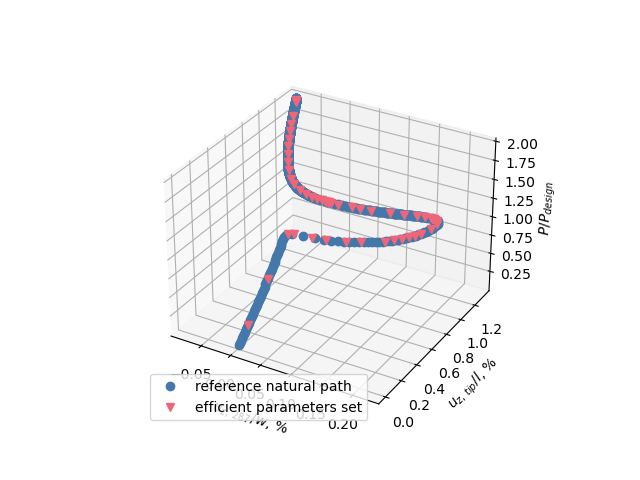

In [11]:
%matplotlib widget
from pyNastran.op2.op2 import read_op2  # pyNastran function to read op2 files

markers = list(Line2D.markers.keys())[2:]  # list of marker characters

notebook_18_analysis_directory_path = os.path.join(os.getcwd(), "analyses", "18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model")  # path to analysis directory
no_elements = len(box_beam_bdf.elements)
sol_105_op2_filepath = os.path.join(notebook_18_analysis_directory_path, f"linear_buckling_{no_elements}_elements.op2")
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)
buckling_subcase_id = 2  # subcase id of buckling analysis
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[buckling_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
MAX_DISPLACEMENT_NODE_ID = sol_105_op2.eigenvectors[buckling_subcase_id].node_gridtype[max_displacement_index, 0]

reference_natural_path_input_name = f"nonlinear_analysis_{no_elements}_elements_maxiter3"
reference_natural_path_op2_filepath = os.path.join(notebook_18_analysis_directory_path, reference_natural_path_input_name + '.op2')
reference_natural_path_op2 = read_op2(op2_filename=reference_natural_path_op2_filepath, load_geometry=True, debug=None)
_, reference_applied_loads, reference_tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=reference_natural_path_op2, displacement_node_id=TIP_MASTER_NODE_ID)
_, _, reference_local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=reference_natural_path_op2,
                                                                                              displacement_node_id=MAX_DISPLACEMENT_NODE_ID)

# Plot benchmark natural path
plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(reference_local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
          reference_tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
          reference_applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, markers[0], label="reference natural path")
ax.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_{design}$")
ax.grid(visible=True)

sol_106_op2_filepath = os.path.join(notebook_18_analysis_directory_path, "nonlinear_analysis_epsp1e-03_epsu1e-03.op2")
sol_106_op2 = read_op2(op2_filename=sol_106_op2_filepath, load_geometry=True, debug=None)
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2,
                                                                                              displacement_node_id=TIP_MASTER_NODE_ID)
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2,
                                                                                    displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
ax.plot3D(local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
          tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
          applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, markers[1], label="efficient parameters set")

# Show plot
ax.legend()
plt.show()

Too many bisections, try to decrease number of iterations.

Now we need to setup the nonlinear analysis with the arc-length method. What parameters are we going to use? In our previous notebooks, we observed that the error function never affected the results of the nonlinear analysis, so we'll stick with the default load and work functions. As far as the convergence tolerances are concerned, we want to make sure that each iteration is well converged, so we'll use the tighest combination of convergence tolerances that we tested in our previous notebooks, that is to say $EPSP=10^{-3}$ and $EPSW=10^{-7}$.

What about the arc-length step size? Ideally, we would like to have a balance between an excessively small step size, which can lead to a very large number of iterations and consequently to a high computational cost, and an excessively large step size, which can make the solver jump away from the natural path onto a complementary path. However, in our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#error-function), we saw that even with a small step size the arc-length solver can jump from one path to the other. The solution to this was to reduce the maximum number of iterations for each load increment below the number of iterations taken by the solver at jump occurrences and to increase the maximum number of bisections allowed for each load increment. In this way, the solver could automatically reduce the step size as much as needed to converge in the prescribed maximum number of iterations. The idea behind this solution is that we want the arc-length solver to converge only to points that are "easy" to converge to, implying that the predictor step lands relatively close to the next equilibrium point of the path.

Looking at the f06 files of our previous notebook, we can find out that most of the "easy" points converge in 2 or 3 iterations. To be on the conservative side, we set $MAXITER=2$ for the nonlinear analyses of our optimization. We also set $MAXBIS=20$, to allow up to 20 bisections for each load increment, and $MINALR=0.01$, to allow the step size to reduce by up to a factor of 100 between successive iterations. Then we need to set the desired number of iterations $DESITER$, which controls the ratio of the step size between successive iterations:

$$\frac{\Delta l_{new}}{\Delta l_{old}}=\sqrt{\frac{DESITER}{I_{max}}},$$

where $I_{max}$ is the number of iterations required to achieve convergence for the last step. We choose $DESITER=2$ so that the step size can only be increased by a factor of $\sqrt{2}$ only if the solver converges in 1 iteration, or kept constant when the solver converges in 2 iterations.

With the above parameters we can obtain a arc-length step size that is able to increase and decrease depending on the "ease" to converge to the next equilibrium point, giving us robustness at a smaller computational cost than a quasi-constant small step size. However, we still need to choose the initial step size, which inevitably affects the first iterations of the nonlinear analysis and consequently the resolution of the equilibrium path along the first nonlinearity (usually the broken-bifurcation-like pattern), depending on its location in the equilibrium manifold.

We are going to test this by running a nonlinear analysis on the initial design of the CRM-like box beam loaded with twice the design load, and by comparing the resulting equilibrium path with the benchmark results of the natural equilibrium path obtained in our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-verification). The idea is to verify whether with the chosen value of initial step size we manage to achieve a satisfying resolution of the natural equilibrium path. We start by setting up the nonlinear analysis with the arc-length method, using the parameters mentioned above and the default value of $NINC=10$, representing an initial step size of 10% of the total applied load. We set the maximum number of controlled increments to 100.

In [12]:
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, conv='PU', eps_p=1e-3, eps_u=1e-3, max_iter=3, max_bisect=20, maxinc=100)

In [13]:
box_beam_bdf.loads[force_set_id][0].mag = DESIGN_LOAD*2  # apply double the design load
desired_iterations = np.arange(3, 9)  # define list of desired numbers of iterations

Nastran job nonlinear_analysis_desiter3.bdf completed
Wall time: 1565.0 s


Nastran job nonlinear_analysis_desiter4.bdf completed
Wall time: 2586.0 s


Nastran job nonlinear_analysis_desiter5.bdf completed
Wall time: 1730.0 s


Nastran job nonlinear_analysis_desiter6.bdf completed
Wall time: 3639.0 s


Nastran job nonlinear_analysis_desiter7.bdf completed
Wall time: 2567.0 s


Nastran job nonlinear_analysis_desiter8.bdf completed
Wall time: 3966.0 s


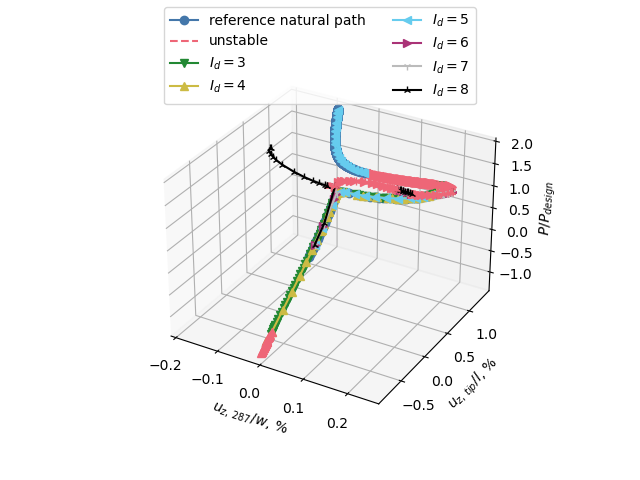

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
UNSTABLE_COLOR = colors[1]  # color for unstable segments
del colors[1]  # delete red from list of colors

# Define function to plot 3D load-displacement diagram segment by segment
def plot_3d_segments(eigvals, axes, local_disp, tip_disp, loads, marker, color):
    negative_eigenvalues_mask = (eigvals < 0).any(axis=0)
    unstable_segments = []  # list to store indices of unstable segments
    stable_segments = []  # list to store indices of stable segments
    # Loop through the negative_eigenvalues_mask to identify and plot segments
    for i, is_negative in enumerate(negative_eigenvalues_mask):
        if is_negative:
            if stable_segments:
                # Plot the stable segment if there was one before
                stable_segments.append(i)  # make the stable segment finish at the first point of the unstable segment
                axes.plot3D(local_disp[stable_segments], tip_disp[stable_segments], loads[stable_segments], marker + '-', color=color)
                stable_segments = []  # reset the stable segment indices
            unstable_segments.append(i)  # add the current index to the unstable segment, this will overwrite the blue point with a red one
        else:
            if unstable_segments:
                # Plot the unstable segment if there was one before
                unstable_segments.append(i)  # make the unstable segment finish at the first point of the stable segment
                axes.plot3D(local_disp[unstable_segments], tip_disp[unstable_segments], loads[unstable_segments],  marker + '--', color=UNSTABLE_COLOR)
                unstable_segments = []  # reset the unstable segment indices
            stable_segments.append(i)  # add the current index to the stable segment, this will overwrite the red point with a blue one
    # Plot the remaining segments if any
    if stable_segments:
        axes.plot3D(local_disp[stable_segments], tip_disp[stable_segments], loads[stable_segments], marker + '-', color=color)
    if unstable_segments:
        axes.plot3D(local_disp[unstable_segments], tip_disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)

# Plot natural equilibrium path
sol_106_f06_filepath = os.path.join(notebook_18_analysis_directory_path, reference_natural_path_input_name + '.f06')
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(sol_106_f06_filepath)
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_3d_segments(eigenvalues, ax, reference_local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
                 reference_tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
                 reference_applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, markers[0], colors[0])
stable_lines = [Line2D([0], [0], linestyle='-', marker=markers[0], color=colors[0], label="reference natural path")]  # create proxy artist for the legend
ax.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_{design}$")
ax.grid(visible=True)

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, color, run_flag=False):
    # Run analysis and read load and displacement history from op2 file
    op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=bdf_input.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
                                                                              analysis_directory_path=ANALYSIS_DIRECTORY_PATH, upper_eig=UPPER_EIGENVALUE, input_name=filename,
                                                                              run_flag=run_flag)
    f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.f06')
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
    _, p, tip_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=TIP_MASTER_NODE_ID)
    _, _, local_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
    # Plot load-displacement curve on input axes
    plot_3d_segments(eigvals, axes, local_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
                     tip_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
                     p[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, marker_style, color)

# Run analysis and plot load-displacement for each desired number of iterations
for count, desiter in enumerate(desired_iterations):
    box_beam_bdf.nlpcis[1].desiter = desiter
    input_filename = f"nonlinear_analysis_desiter{desiter:d}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[1 + count],
                                 colors[1 + count], run_flag=False)
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=markers[1 + count], color=colors[1 + count],
                               label=f"$I_d={desiter:d}$"))  # create proxy artist for the legend

# Show plot
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=[stable_lines[0], unstable_line] + stable_lines[1:], loc="upper center", bbox_to_anchor=(0.5, 1.), ncol=2)
plt.show()

Rerun with tighter tolerances.

Nastran job nonlinear_analysis_epsp1e-4_desiter3.bdf completed
Wall time: 3688.0 s


Nastran job nonlinear_analysis_epsp1e-4_desiter4.bdf completed
Wall time: 2494.0 s


Nastran job nonlinear_analysis_epsp1e-4_desiter5.bdf completed
Wall time: 2512.0 s


Nastran job nonlinear_analysis_epsp1e-4_desiter6.bdf completed
Wall time: 2577.0 s


Nastran job nonlinear_analysis_epsp1e-4_desiter7.bdf completed
Wall time: 2579.0 s


Nastran job nonlinear_analysis_epsp1e-4_desiter8.bdf completed
Wall time: 2258.0 s


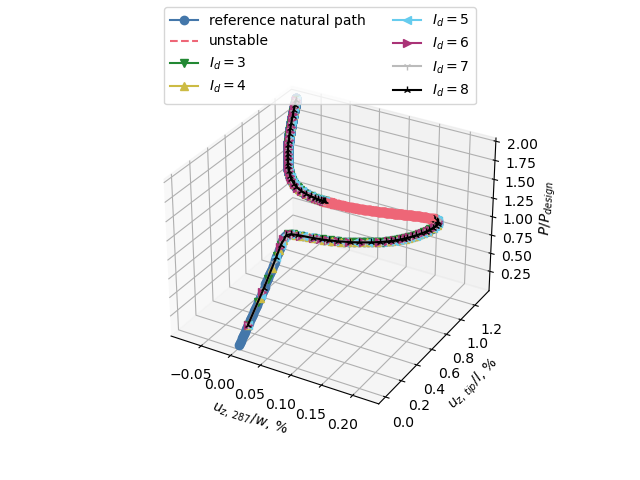

In [15]:
box_beam_bdf.nlparms[1].eps_p = 1e-4
box_beam_bdf.nlparms[1].eps_u = 1e-4
box_beam_bdf.nlpcis[1].mxinc = 300

# Plot natural equilibrium path
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_3d_segments(eigenvalues, ax, reference_local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
                 reference_tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
                 reference_applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, markers[0], colors[0])
stable_lines = [Line2D([0], [0], linestyle='-', marker=markers[0], color=colors[0], label="reference natural path")]  # create proxy artist for the legend
ax.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_{design}$")
ax.grid(visible=True)

# Run analysis and plot load-displacement for each desired number of iterations
for count, desiter in enumerate(desired_iterations):
    box_beam_bdf.nlpcis[1].desiter = desiter
    input_filename = f"nonlinear_analysis_epsp1e-4_desiter{desiter:d}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[1 + count],
                                 colors[1 + count], run_flag=False)
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=markers[1 + count], color=colors[1 + count],
                               label=f"$I_d={desiter:d}$"))  # create proxy artist for the legend

# Show plot
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=[stable_lines[0], unstable_line] + stable_lines[1:], loc="upper center", bbox_to_anchor=(0.5, 1.), ncol=2)
plt.show()

Nastran job nonlinear_analysis_ninc11_desiter3.bdf completed
Wall time: 3491.0 s


Nastran job nonlinear_analysis_ninc11_desiter4.bdf completed
Wall time: 2002.0 s


Nastran job nonlinear_analysis_ninc11_desiter5.bdf completed
Wall time: 1576.0 s


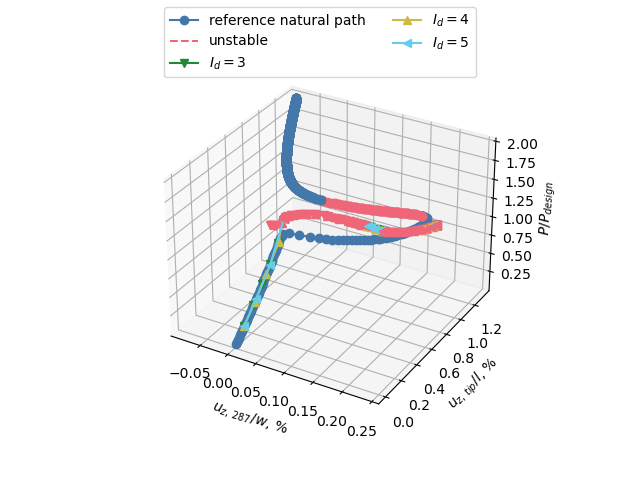

In [16]:
box_beam_bdf.nlparms[1].ninc = 11
desired_iterations = np.arange(3, 6)  # define list of desired numbers of iterations

# Plot natural equilibrium path
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_3d_segments(eigenvalues, ax, reference_local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
                 reference_tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
                 reference_applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, markers[0], colors[0])
stable_lines = [Line2D([0], [0], linestyle='-', marker=markers[0], color=colors[0], label="reference natural path")]  # create proxy artist for the legend
ax.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_{design}$")
ax.grid(visible=True)

# Run analysis and plot load-displacement for each desired number of iterations
for count, desiter in enumerate(desired_iterations):
    box_beam_bdf.nlpcis[1].desiter = desiter
    input_filename = f"nonlinear_analysis_ninc11_desiter{desiter:d}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[1 + count],
                                 colors[1 + count], run_flag=False)
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=markers[1 + count], color=colors[1 + count],
                               label=f"$I_d={desiter:d}$"))  # create proxy artist for the legend

# Show plot
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=[stable_lines[0], unstable_line] + stable_lines[1:], loc="upper center", bbox_to_anchor=(0.5, 1.), ncol=2)
plt.show()

We can see that our analysis achieves a satisfying resolution of the natural equilibrium path around the first nonlinearity, but it fails to traverse the instability past the limit point. Looking at the f06 file we find out that the analysis failed because the last solution regressed to an earlier load step with both root-selection algorithms of Crisfield's method. This fatal error is also the cause of the isolated orange point that can be observed in the plot. In fact, for an unknown reason when SOL 106 terminates because of the above reason, Nastran saves in the op2 file an final artificial equilibrium point having the same displacement of the last converged load step and the final applied load prescribed by the input file.

Nevertheless, the analysis was still able to detect the first two unstable points after the limit point, as the last two converged load steps show a negative eigenvalue of the tangent stiffness matrix. which is enough for our optimization purposes. In fact, thanks to the KS aggregation approach, we only need one eigenvalue to become negative during the analysis to activate the constraint.

Let's plot the eigenvalues against the applied load for both the benchmark and the last nonlinear analysis.

In [17]:
# # Read eigenvalues obtained with refence analysis
# f06_path = os.path.join(notebook_18_analysis_directory_path, reference_input_name + ".f06")  # path to .f06 file
# eigenvalues_reference = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# # Read eigenvalues obtained with verification analysis
# f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + ".f06")  # path to .f06 file
# eigenvalues_ninc10 = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# # Create figure with two subplots sharing the x-axis
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# # Plot for refence analysis
# ax1.plot(reference_applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, eigenvalues_reference.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
# ax1.set_ylabel("$\lambda$, N/m (reference)")
# ax1.grid(True)

# # Plot for verification analysis
# ax2.plot(applied_loads[FIRST_SUBCASE_ID][:-1, Z_AXIS_INDEX]/design_load, eigenvalues_ninc10.T*1e3, 'o')  # remove last applied load and convert eigenvalues from N/mm to N/m
# ax2.set_xlabel("$P/P_{design}$")
# ax2.set_ylabel("$\lambda$, N/m ($NINC=10$)")
# ax2.grid(True)

# # Adjust layout for better appearance
# plt.tight_layout()
# plt.show()

From the above eigenvalue diagram we notice a slight difference in the applied load where the first eigenvalue becomes negative. Let's calculate the percentage difference between our last analysis and the reference.

In [18]:
# # Find applied load of reference analysis where the first negative eigenvalue occurs
# index_reference_negative = next((i for i in range(eigenvalues_reference.shape[1]) if np.any(eigenvalues_reference[:, i] < 0)))  # identify the index of the first column with a negative eigenvalue
# applied_load_reference_negative = reference_applied_loads[FIRST_SUBCASE_ID][index_reference_negative, Z_AXIS_INDEX] / design_load

# # Find applied load of verification analysis where the first negative eigenvalue occurs
# index_ninc10_negative = next((i for i in range(eigenvalues_ninc10.shape[1]) if np.any(eigenvalues_ninc10[:, i] < 0)))  # identify the index of the first column with a negative eigenvalue
# applied_load_ninc10_negative = applied_loads[FIRST_SUBCASE_ID][index_ninc10_negative, Z_AXIS_INDEX] / design_load

# # Calculate the percentage difference between the applied loads where the first negative eigenvalue occurs
# print(f"Percentage difference between applied loads where the first negative eigenvalue occurs: {(applied_load_ninc10_negative/applied_load_reference_negative-1)*100:.1f}%")

Our analysis with the initial step size of 10% of the total applied load finds the limit point at an applied load that is 1.4% larger than the reference. We consider this difference to be acceptable, so we are going to proceed with $NINC=10$ for the optimization. Nevertheless, the observed difference should remind us that a relatively large initial step size can introduce errors in the calculated equilibrium points and consequently affect the accuracy of the final results of the analysis.

Before moving to our first optimization, we restore the original design load in the FORCE card.

In [19]:
# box_beam_bdf.loads[force_set_id][0].mag = design_load

## First optimization <a name="first-optimization"></a>

***

Now we are ready to set up and run our first optimization. To set it up, we need to define an instance of our `BoxBeamGroup` and pass it to the constructor of the OpenMDAO `Problem` class. Then we call the `setup()` method to get the data structures of the framework in place.

In [20]:
box_beam_model = BoxBeamGroup(bdf_object=box_beam_bdf)
prob = om.Problem(model=box_beam_model)
prob.setup()

To get the reference values of our objective and constraints functions, corresponding to the one of the initial design, we assign the initial value of wall thickness to the design variable and run our `Problem` object with the method `run_model`.

In [21]:
prob.set_val("sol_106.t", t0)
initial_design_input_name = "box_beam_sol_106_start"
prob.set_val("sol_106.input_name", initial_design_input_name)
prob.set_val("sol_106.run_flag", False)
prob.run_model()
mass_0 = prob["sol_106.mass"][0]
ks_stability_0 = prob["sol_106.ks_stability"][0]
ks_stress_0 = prob["sol_106.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial thickness: {t0:.1f} mm
Initial KS value for stability: {ks_stability_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job box_beam_sol_106_start.bdf completed
Wall time: 66.0 s


Initial mass: 6519 kg
Initial thickness: 7.7 mm
Initial KS value for stability: -20.8 N/m
Initial KS value for stress: -400 MPa


Now we set up the optimization problem by defining the default input values of the `Sol106Comp` component, by selecting the COBYLA algorithm as optimizer, and by defining the design variable, objective and constraints together with their bounds and scaling factors.

In [22]:
# Set default input values of sol_106 component
prob.model.set_input_defaults("sol_106.t", t0)
prob.model.set_input_defaults("sol_106.input_name", "box_beam_sol_106_opt")
prob.model.set_input_defaults("sol_106.run_flag", False)

# Choose optimizer
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options["optimizer"] = "COBYLA"
prob.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
prob.model.add_design_var("sol_106.t", lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
prob.model.add_objective("sol_106.mass", ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
prob.model.add_constraint("sol_106.ks_stability", upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
prob.model.add_constraint("sol_106.ks_stress", upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
prob.model.add_constraint("sol_106.applied_load", lower=DESIGN_LOAD*.99, ref=DESIGN_LOAD)  # scale applied load so that design load is 1

Before running the optimization, we are going to create a recorder and attach it to our `Problem` object. This will allow us to save the values of the design variable, objective and constraints at each iteration of the optimization.

In [23]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "first_optimization.sql")
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
prob.driver.add_recorder(recorder)  # attach recorder to the driver

Finally, we can run the optimization calling the method `run_driver` of our `Problem` object.

In [24]:
prob.setup()  # re-setup problem
prob.set_solver_print(0)  # disable solver output
prob.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    prob.run_driver()  # run optimization
prob.cleanup()  # clean up problem

Let's plot the convergence history of the optimization.

Mass variation: -90.2 %
Final thickness: 0.8 mm
Final KS value of nonlinear structural stability: 9.74 N/m
Final KS value for stress: -419 MPa


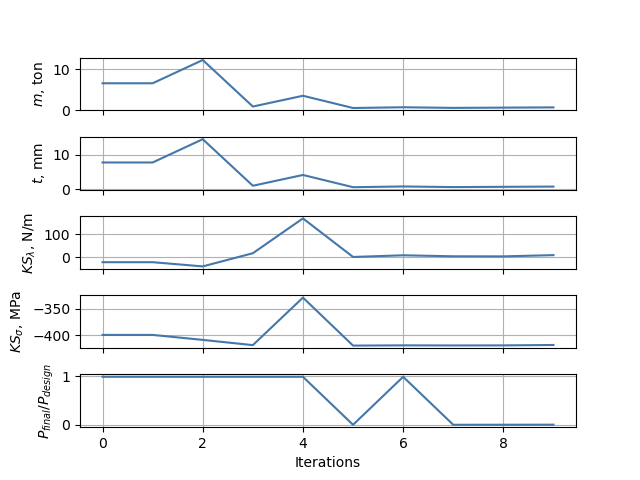

In [25]:
# Instantiate CaseReader object
cr = om.CaseReader(recorder_filepath)

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases("driver", recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ["sol_106.mass", "sol_106.t", "sol_106.ks_stability", "sol_106.ks_stress", "sol_106.applied_load"]  # keys of the functions to retrieve
histories = {key: np.stack([case[key][0] for case in driver_cases], axis=0) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_percentage_variation = (histories["sol_106.mass"][-1]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.1f} %
Final thickness: {histories["sol_106.t"][-1]:.1f} mm
Final KS value of nonlinear structural stability: {histories["sol_106.ks_stability"][-1]:.2f} N/m
Final KS value for stress: {histories["sol_106.ks_stress"][-1]:.0f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Plot mass history
iterations_array = np.arange(len(histories["sol_106.mass"]))
ax1.plot(iterations_array, histories["sol_106.mass"])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories["sol_106.t"])
ax2.set(ylabel="$t$, mm")
ax2.grid()

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories["sol_106.ks_stability"])
ax3.set(ylabel="$KS_{\lambda}$, N/m")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories["sol_106.ks_stress"])
ax4.set(ylabel="$KS_{\sigma}$, MPa")
ax4.grid()

# Plot applied load history
ax5.plot(iterations_array, histories["sol_106.applied_load"]/DESIGN_LOAD)
ax5.set(xlabel="Iterations", ylabel="$P_{final}/P_{design}$")
ax5.grid()

# Show plot
plt.show()

What is the linear buckling load of the optimized design?

subcase=1 already exists...skipping


Nastran job box_beam_opt_sol_105.bdf completed
Wall time: 15.0 s


P_sol105/P_design = 0.71
Buckling mode:


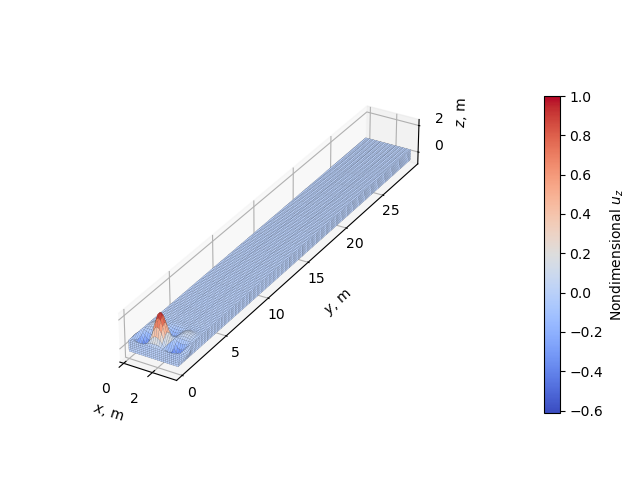

In [26]:
# Assign final thickness to PSHELL card
pid = 1
box_beam_bdf.properties[pid].t = histories["sol_106.t"][-1]

# Run SOL 105 and return OP2 file
input_name = "box_beam_opt_sol_105"
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf, static_load_set_id=force_set_id, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                            input_name=input_name, run_flag=False)

# Find critical buckling load and print it
eigenvalue_calculation_subcase_id = 2
nondimensional_linear_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f"P_sol105/P_design = {nondimensional_linear_buckling_load:.2f}")
# Plot critical buckling mode
# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards
print("Buckling mode:")
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='tz', colormap='coolwarm',
                                                 length_unit='m', displacement_amplification_factor=2, unit_scale_factor=1e-3)
adjust_3d_plot(ax, cbar)
plt.show()

Let's plot the equilibrium diagram comparing the intial and final design.


ndata = 0:
  strings = (b'',)
  ints    = ()
  floats  = ()



FatalError: There was a Nastran FATAL Error.  Check the F06.
last table=b'CASECC'; post=-1 version='msc'

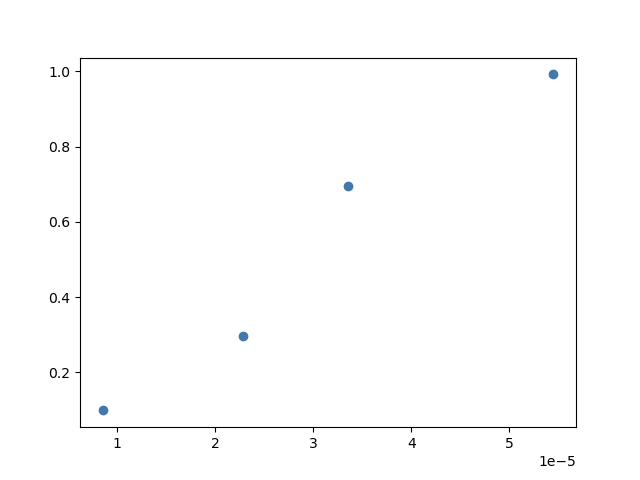

In [27]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors
input_name_dict = {initial_design_input_name: "initial design", DEFAULT_INPUT_NAME: "final design"}
sol_106_op2 = {}
applied_loads = {}
local_displacements = {}
plt.figure()
for count, key in enumerate(input_name_dict.keys()):
    sol_106_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, key + ".op2")
    sol_106_op2[key] = read_op2(op2_filename=sol_106_op2_filepath, load_geometry=True, debug=None)
    _, applied_loads[key], local_displacements[key] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2[key],
                                                                                                              displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
    plt.plot(local_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w, applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD,
              markers[count], label=input_name_dict[key])

# Plot line of glass ceiling of linear buckling for final design
plt.axhline(y=nondimensional_linear_buckling_load, color=colors[2], linestyle="--", label="glass ceiling of linear buckling (final design)")

# Set plot appearance
plt.xlabel(f"$u_{{z, {MAX_DISPLACEMENT_NODE_ID:d}}}/w$")
plt.ylabel("$P/P_{design}$")
plt.locator_params(axis="x", nbins=5)  # set number of ticks of x-axis
plt.grid(visible=True)
plt.legend()
plt.show()

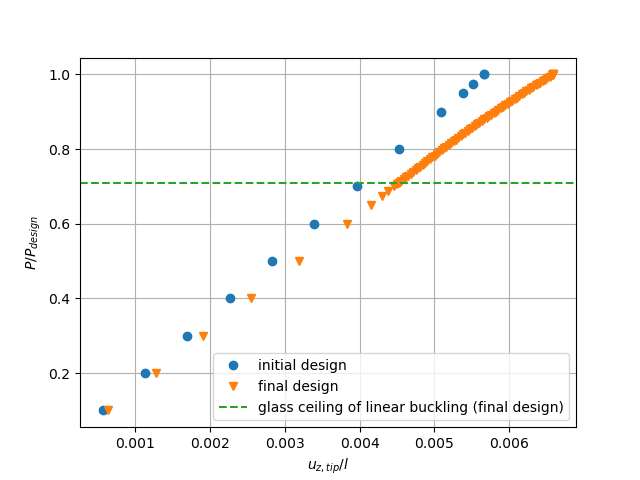

In [ ]:
tip_displacements = {}
plt.figure()
for count, key in enumerate(input_name_dict.keys()):
    _, _, tip_displacements[key] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2[key],
                                                                                           displacement_node_id=TIP_MASTER_NODE_ID)
    plt.plot(tip_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l, applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD,
              markers[count], label=input_name_dict[key])
    
# Plot line of glass ceiling of linear buckling for final design
plt.axhline(y=nondimensional_linear_buckling_load, color=colors[2], linestyle="--", label="glass ceiling of linear buckling (final design)")

# Set plot appearance
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_{design}$")
plt.grid(visible=True)
plt.legend()
plt.show()

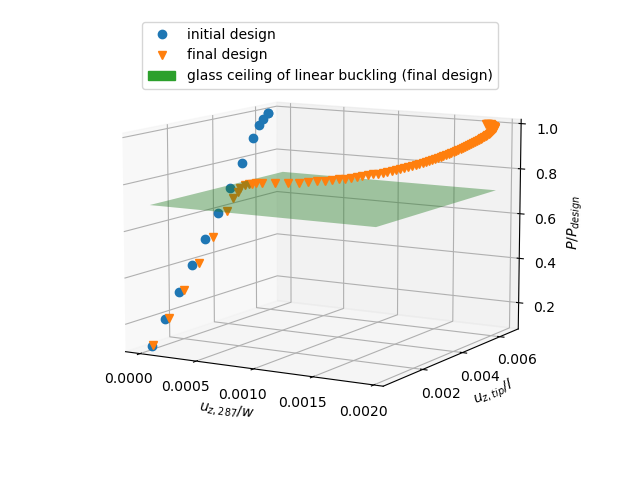

In [ ]:
import matplotlib.patches as mpatches

plt.figure()
ax = plt.axes(projection="3d")

legend_handles = []

for count, key in enumerate(input_name_dict.keys()):
    # For the first time of plotting a particular type, add the label to create its legend entry
    label = input_name_dict[key] if input_name_dict[key] not in [handle.get_label() for handle in legend_handles] else ""
    
    line, = ax.plot3D(local_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w, 
                      tip_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l,
                      np.where(applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD < nondimensional_linear_buckling_load,
                               applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, np.nan), 
                      markers[count], color=colors[count], label=label)
    if label:  # add handle only for the first time
        legend_handles.append(line)

# Plot plane
local_displacements_array = np.concatenate(tuple(local_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w for key in local_displacements))
tip_displacements_array = np.concatenate(tuple(tip_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l for key in tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array),
                                                                                              np.max(tip_displacements_array)])
ax.plot_surface(xx, yy, np.full_like(xx, nondimensional_linear_buckling_load), alpha=0.4, color=colors[2])

proxy_surface = mpatches.Patch(color=colors[2], label="glass ceiling of linear buckling (final design)")
legend_handles.append(proxy_surface)

# Plot part of the equilibrium paths that should be visible on top of the plane
for count, key in enumerate(input_name_dict.keys()):
    ax.plot3D(local_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w, 
              tip_displacements[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l,
              np.where(applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD > nondimensional_linear_buckling_load,
                       applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, np.nan), 
              markers[count], color=colors[count], zorder=3)

# Set plot appearance
ax.view_init(10, -60)
ax.locator_params(axis="x", nbins=5)  # set number of ticks of x-axis
ax.locator_params(axis="y", nbins=4)  # set number of ticks of y-axis
ax.set_xlabel(f"$u_{{z, {MAX_DISPLACEMENT_NODE_ID:d}}}/w$")
ax.set_ylabel("$u_{z, tip}/l$")
ax.set_zlabel("$P/P_{design}$")
ax.grid(visible=True)
plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, 1.), loc='upper center')
plt.tight_layout()
plt.show()

Let's plot the eigenvalues of the tangent stiffness matrix of the final design.

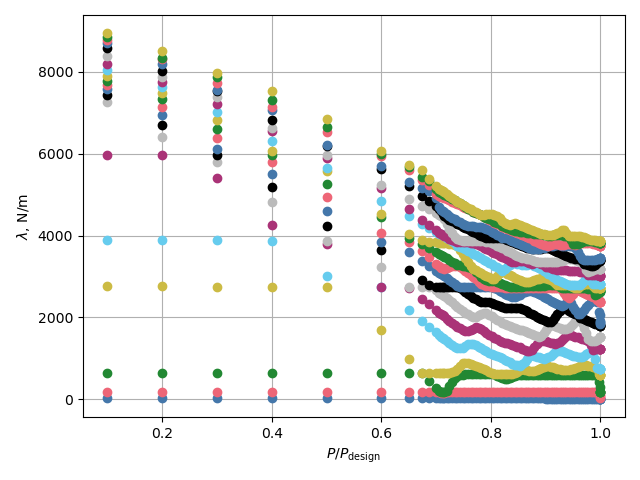

In [ ]:
import tol_colors as tc  # package for colorblind-friendly colors

# Read eigenvalues obtained with refence mesh
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, DEFAULT_INPUT_NAME + ".f06")  # path to .f06 file
eigenvalues_reference_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create the figure
plt.rc("axes", prop_cycle=plt.cycler("color", list(tc.tol_cset("bright"))))  # set default color cycle to TOL bright
plt.figure()

# Plot for refence mesh
plt.plot(applied_loads[key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD, eigenvalues_reference_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda$, N/m")
plt.xlabel("$P/P_\mathrm{design}$")
plt.grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

Let's plot the deformation at the design load comparing the intial and final design.

Deformation of initial design at design load:


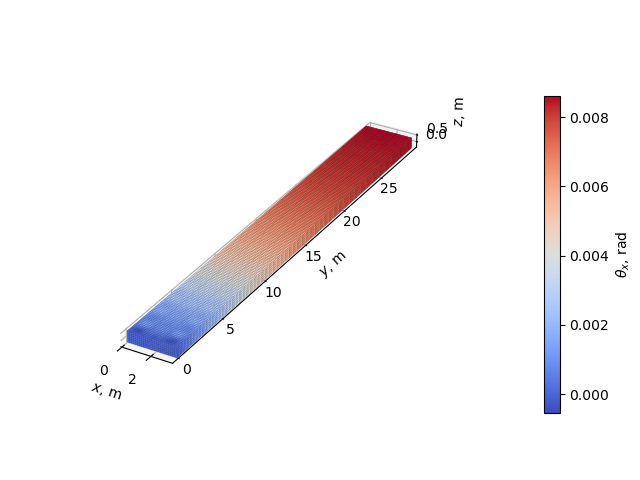

Deformation of final design at design load:


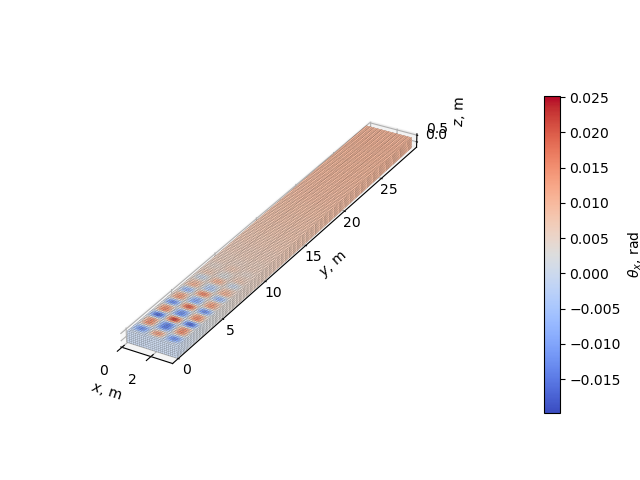

In [ ]:
# Plot deformed shape of the box beam at design load
for key in input_name_dict.keys():
    print(f"Deformation of {input_name_dict[key]} at design load:")
    _, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[key], displacement_component="rx", colormap="coolwarm",
                                                          length_unit="m", unit_scale_factor=1e-3)  # convert displacements from mm to m
    adjust_3d_plot(ax, cbar)
    plt.show()
    plt.savefig(f"{input_name_dict[key]}.png", dpi=300)